In [1]:
import dagstermill as dm
from event_pipeline_demo.repository import define_repo
dm.register_repository(define_repo())

In [ ]:
import os

import geopandas as geo
import matplotlib.pyplot as plt
import pandas as pd
import snowflake.connector

from matplotlib.backends.backend_pdf import PdfPages

In [52]:
%matplotlib inline

In [53]:
ACCOUNT = os.getenv('SNOWFLAKE_ACCOUNT')
USER = os.getenv('SNOWFLAKE_USER')
PASSWORD = os.getenv('SNOWFLAKE_PASSWORD')

In [54]:
conn = snowflake.connector.connect(
  user=USER,
  password=PASSWORD,
  account=ACCOUNT,
)


In [55]:
cursor = conn.cursor()

In [56]:
queries = [
    "use warehouse TINY_WAREHOUSE;",
    "use database TESTDB;",
    "use schema TESTSCHEMA;",
    """select
        parse_json(location):latitude :: float as latitude,
        parse_json(location):longitude :: float as longitude,
        timestamp
    from (
      select
        parse_json(data):location as location,
        parse_json(data): timestamp :: timestamp as timestamp
      from events
      order by timestamp desc
      limit 10000
    );
    """
]

In [57]:
for query in queries:
    cursor.execute(query)

In [59]:
assert cursor.rowcount == 10000

In [60]:
rows = cursor.fetchall()

In [61]:
df = pd.DataFrame(rows, columns=['latitude', 'longitude', 'timestamp'])

In [62]:
df.head()

,latitude,longitude,timestamp
0,46.18396,6.10237,2019-01-02 15:59:59
1,37.74615,-25.66689,2019-01-02 15:59:57
2,-30.60106,-71.19901,2019-01-02 15:59:54
3,35.85000,117.70000,2019-01-02 15:59:52
4,6.03333,37.55000,2019-01-02 15:59:47


In [63]:
world = geo.read_file(geo.datasets.get_path('naturalearth_lowres'))

In [ ]:
pdf_path = 'geo_events.pdf'
pdf = PdfPages(pdf_path)

Text(0.5, 1.0, 'Geographic distribution of last 10k events')

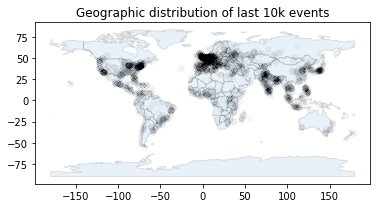

In [67]:
world.plot(alpha=0.1, edgecolor="black")

plt.plot(df['longitude'],  df['latitude'], 'ko', alpha=0.005)
plt.title("Geographic distribution of last 10k events")

In [ ]:
pdf.close()

In [ ]:
dm.yield_result(pdf_path, 'pdf_path')